# Working zfourge luminosity function notebook with minimum code

This produces a single luminosity function with one redshift bin

In [124]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from astropy.cosmology import FlatLambdaCDM

zmin = 0.1
zmax = 0.9
survey_area = 0.11 # square degrees zfourge
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
mlim = 27 # CDFS apparent magnitude limit

# Read in CDFS main data
data = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN.csv')
df = pd.DataFrame(data)
df = df[df['Use'] == 1]
df = df[df['zpk'] >= zmin]
df = df[df['zpk'] <= zmax]
# df = df[df['FKs'] <= mlim]
print(f'Number of sources: {len(df)}')

z = df['zpk'] # redshift
m_app = df['FKs'] # apparent magnitude

Number of sources: 3867


### Convert apparent magnitude to apparent AB magnitude and then to absolute magnitude

In [125]:
dists = cosmo.comoving_distance(z).value # Mpc
m_ab = 25 - 2.5*np.log10(m_app) # AB magnitude
M_abs = m_ab - 5 * np.log10(dists / 10) # absolute magnitude

C:\Users\n10480129\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Uncorrected luminosity function

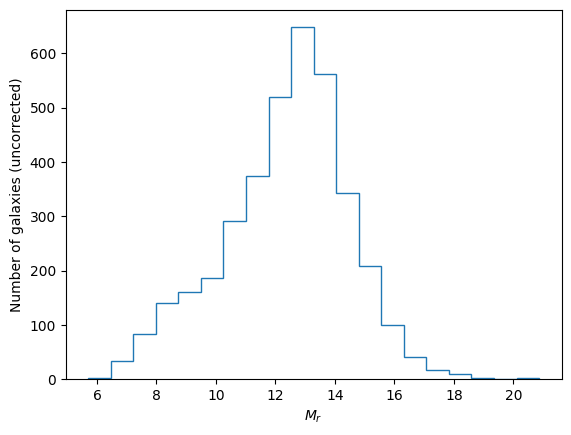

Number of galaxies in each bin: [  2.  34.  84. 140. 161. 187. 292. 374. 520. 648. 562. 343. 208. 100.
  41.  18.  10.   3.   1.   2.]


In [145]:
counts, bin_edges, _ = plt.hist(M_abs, bins=20, histtype='step')
plt.xlabel('$M_r$')
plt.ylabel('Number of galaxies (uncorrected)')
plt.show()
print('Number of galaxies in each bin:', counts)

### Calculate the volume probed in each luminosity bin

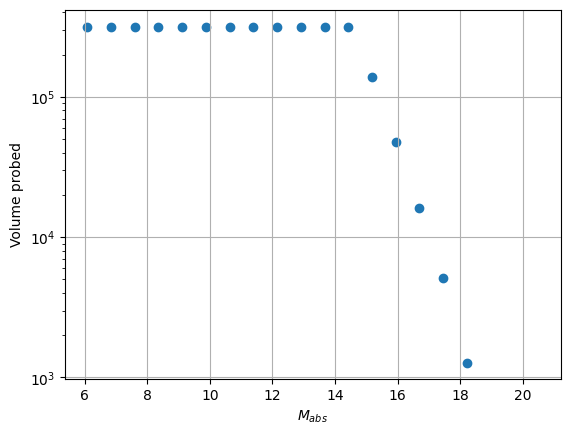

dmaxs: [3053.34660668 3053.34660668 3053.34660668 3053.34660668 3053.34660668
 3053.34660668 3053.34660668 3053.34660668 3053.34660668 3053.34660668
 3053.34660668 3053.34660668 2312.89083178 1631.4234762  1150.74283755
  811.68936054  572.53418967  403.84340891  284.85547565  200.92600304]
dmin: 418.4544876277049
dmax: 3053.3466066797323
vol: [ 3.17128113e+05  3.17128113e+05  3.17128113e+05  3.17128113e+05
  3.17128113e+05  3.17128113e+05  3.17128113e+05  3.17128113e+05
  3.17128113e+05  3.17128113e+05  3.17128113e+05  3.17128113e+05
  1.37376219e+05  4.76798199e+04  1.62016318e+04  5.15462946e+03
  1.27777797e+03 -8.27700778e+01 -5.60242840e+02 -7.27807844e+02]


In [146]:
# Calculate the central value of each luminosity bin
bin_centers = bin_edges[0:-1] + np.diff(bin_edges)[0] / 2

# Calculate the minimum and maximum distance of the redshift bin
dmin = cosmo.comoving_distance(zmin).value
dmax = cosmo.comoving_distance(zmax).value

# Calculate the maximum distance of each luminosity bin
dmaxs = 10 * 10 ** ((mlim - bin_centers) / 5)

# If the maximum distance is greater than the maximum redshift bin distance, set it to the maximum redshift bin distance
dmaxs[dmaxs > dmax] = dmax

# Calculate the minimum volume of the redshift bin
vmin = 4/3 * np.pi * dmin**3

# Calculate the maximum volume of each luminosity bin
vmaxs = 4/3 * np.pi * dmaxs**3

# Total volume probed accounting for survey area
vol = (vmaxs - vmin) * survey_area / (41253)

# Plot the volume probed as a function of absolute magnitude
plt.scatter(bin_centers, vol)
plt.yscale('log')
plt.xlabel(r'$M_{abs}$')
plt.ylabel('Volume probed')
plt.grid()
plt.show()

print(f'dmaxs: {dmaxs}')
print(f'dmin: {dmin}')
print(f'dmax: {dmax}')
print(f'vol: {vol}')

### Corrected Luminosity Function

Text(0, 0.5, '$log(\\phi$ [Mpc$^{-3}$ $M_{AB}^{-1}$])')

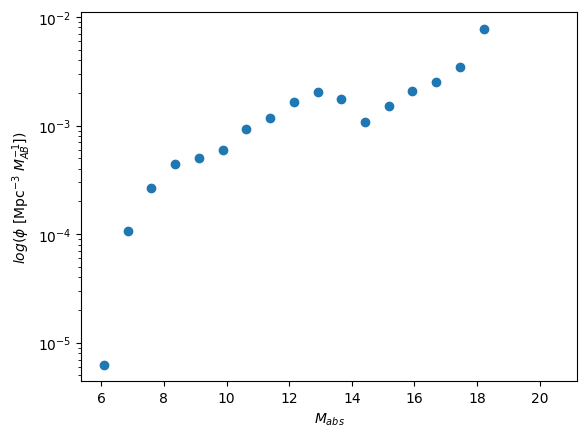

In [147]:
lf = counts / vol
plt.scatter(bin_centers, lf)
plt.yscale('log')
plt.xlabel(r'$M_{abs}$')
plt.ylabel(r'$log(\phi$ [Mpc$^{-3}$ $M_{AB}^{-1}$])')

### Luminosity Function with Schechter fit

Schechter fit:
phistar = -4197.753032233216
Lstar = -3865.6401134383163
alpha = -21.42711168849629


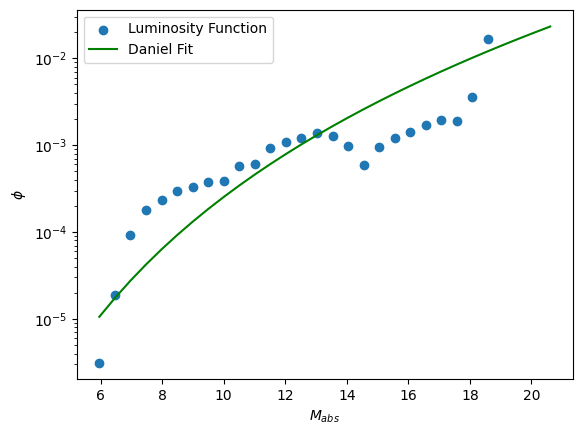

In [140]:
from scipy.optimize import curve_fit

def schechter(L, phistar, Lstar, alpha) :
#     # return phistar * ((L / Lstar) ** (1 - alpha)) * np.exp(-L / Lstar)
#     # return phistar * np.sign(L / Lstar) * (np.abs(L / Lstar) ** (1 - alpha)) * np.exp(-L / Lstar) + c
    return phistar * np.sign(L / Lstar) * (np.abs(L / Lstar) ** (1 - alpha)) * np.exp(-L / Lstar)

# def schechter(m,mstar=-21,alpha=-1,phistar=1) :
#     return phistar*10.**(-0.4*(alpha+1)*(m-mstar))*np.exp(-10.**(-0.4*(m-mstar)))
    
p0 = [-10, -60, -5] # Initial guess for fit parameters
# bounds = ([-100, -10, -100], [100, 10, 100]) # Bounds for fit parameters
params, covars = curve_fit(schechter, bin_centers, lf, p0=p0, nan_policy='omit', maxfev=10000)
print('Schechter fit:')
print(f'phistar = {params[0]}')
print(f'Lstar = {params[1]}')
print(f'alpha = {params[2]}')
# print(f'c = {params[3]}')

plt.scatter(bin_centers, lf, label='Luminosity Function') # Plot the corrected LF
# plt.plot(bin_centers, schechter(bin_centers, *params), color='red', label='Schechter Fit') # Plot the Schechter fit
plt.plot(bin_centers, schechter(bin_centers, *[-10, -60, -5]), color='green', label='Daniel Fit') # Plot the Schechter fit
plt.xlabel('$M_{abs}$')
plt.ylabel('$\phi$')
plt.yscale('log')
plt.legend()
plt.show()